In [50]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
from importlib import reload
import encasm.env
reload(encasm.env)
from encasm.env import PetriDish

In [53]:
test_env = PetriDish.from_config_file("test", "./encasm/configs/default_config.ini")

In [54]:
import scipy.signal as signal

import utils.videowriter
reload(utils.videowriter)
from utils.videowriter import VideoWriter
import encasm
reload(encasm)
import encasm.eval
reload(encasm.eval)
from encasm.eval import load_tests

data_dir = "./encasm/example_networks/"
test_envs = load_tests(folder = data_dir)

import encasm.env
reload(encasm.env)
from encasm.env import PetriDish


In [55]:
# applies a 2d convolution to the grid using scipy and the given kernel
def convolve(grid, kernel):
    return signal.convolve2d(grid, kernel, mode='same', boundary='fill', fillvalue=0)

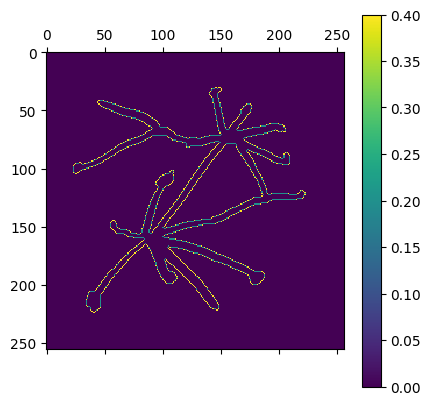

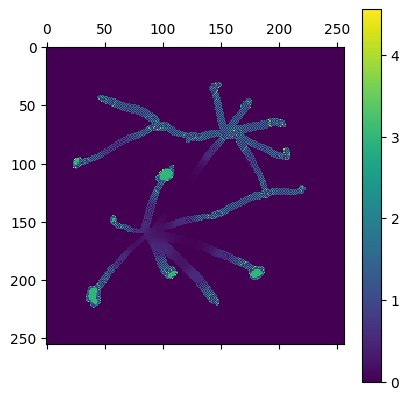

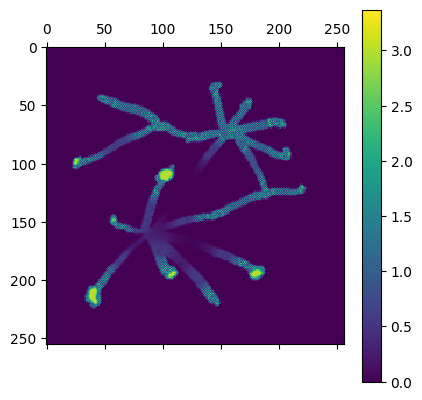

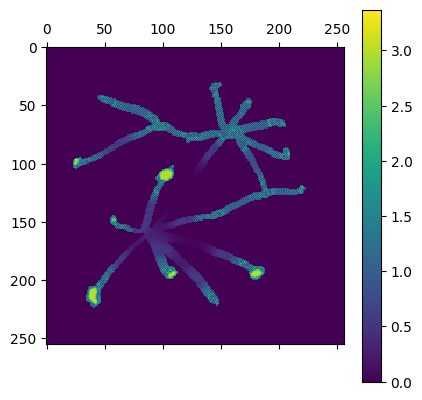

In [56]:


kernel = np.array([[0,1,0],[1,0,1],[0,1,0]], dtype=np.float32)
# Represents the percentage of nutrients lost to diffusion outside of the road network
edge_reinforcer = convolve(tenv.life == 0, kernel) * tenv.life*0.2
kernel[1,1] = 1
kernel = kernel * 0.2
plt.matshow(edge_reinforcer)
plt.colorbar()
# shows result in between each step
tenv.resv += tenv.resv * edge_reinforcer # Nutrients that would leave the cell stays in
plt.matshow(tenv.resv)
plt.colorbar()

diffused = convolve(tenv.resv, kernel)
plt.matshow(diffused)
plt.colorbar()
tenv.resv = diffused*tenv.life
plt.matshow(tenv.resv)
plt.colorbar()

In [134]:
def diffuse(r,l, cutoff=0.5):
    l = l>0 # convert to boolean in case it isn't

    kernel = np.array([[0,1,0],[1,0,1],[0,1,0]], dtype=np.float32)
    # plt.matshow(r)
    # plt.colorbar()
    # print(r.sum())
    free_cells = (r<cutoff) & l # A free cell is alive and isn't full of nutrients
    sources = r > cutoff # purely cells that are full

    # How large of an area could a cell's resevoir flow to
    flow_area = convolve(free_cells, kernel) * l
    flow_area[l] += 1 # every cell includes itself

    # Nonzero just avoids divide by zero, this is just 5/flow_area * r, which is the adjusted nutrients 
    # to "bounce back" diffusion off of full cells and voids
    to_diff = np.divide(5., flow_area, out=np.zeros_like(r), where=flow_area!=0) * r

    kernel[1,1] = 1
    kernel = kernel * 0.2
    sinks = convolve(to_diff, kernel) * free_cells # sinks serve as sources to other sinks too


    # creates an array where free_cells have the value of sinks and sources have the value of to_diff * 0.2
    diffused = np.zeros_like(r)
    diffused[free_cells] = sinks[free_cells]
    diffused[sources] = to_diff[sources] * 0.2
    # plt.matshow(diffused)
    # plt.colorbar()
    # print(diffused.sum())
    return diffused

In [74]:
# tenv = PetriDish.from_env("tenv", test_envs["small"]['3']['1'])
# tenv.resv += tenv.food

# an 8 by 8 array representing an elbow bend road of life
l = np.array([[0,1,1],
              [0,1,1],
              [0,1,0]], dtype=np.float32)
r = np.array([[0,1,1],
              [0,1,0],
              [0,0,0]], dtype=np.float32)


In [75]:

# diffuses 10 times and shows makes a video
with VideoWriter(filename="./encasm/results/diffusion.mp4", fps=100) as vw:
    for i in range(100):
        r = diffuse(r,l)
        vw.add_concat_grids([r,l], cols=2)

In [188]:
tenv = PetriDish.from_env("tenv", test_envs["large"]['6']['4'])

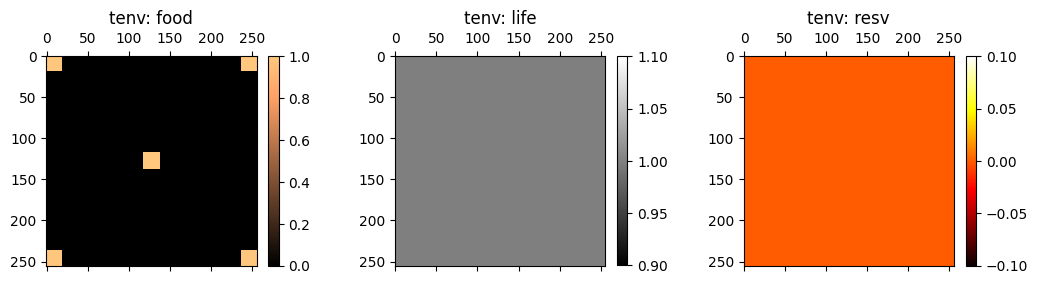

In [189]:
tenv.food = np.zeros_like(tenv.life)
tenv.life = np.ones_like(tenv.life)
# places blocks of food the size of sz in the corners and middle of a the food grid
sz=20
tenv.food[:sz,:sz] = 1
tenv.food[-sz:,-sz:] = 1
tenv.food[-sz:,:sz] = 1
tenv.food[:sz,-sz:] = 1
tenv.food[tenv.food.shape[0]//2-sz//2:tenv.food.shape[0]//2+sz//2,tenv.food.shape[1]//2-sz//2:tenv.food.shape[1]//2+sz//2] = 1


tenv.display()


In [191]:
from PIL import Image
# saves an image of tenv food
# Image.fromarray((tenv.food*255).astype(np.uint8)).save("./encasm/results/food.png")
# saves an image of tenv life in example large



In [187]:
import math
# Records a video of diffusion in tenv
with VideoWriter("./encasm/results/diffusion.mp4", fps=33) as vid:
    vid.add_concat_grids([tenv.resv], cols = 1)
    print(tenv.resv.sum())

    for i in range(200):
        tenv.resv += tenv.food * 0.2
        tenv.resv = np.clip(tenv.resv, 0, 3)
        tenv.resv = diffuse(tenv.resv, tenv.life, cutoff=0.3)
        # sets 10% of all life cells to 0
        # tenv.resv[tenv.life.nonzero()] *= np.random.rand(*tenv.life[tenv.life.nonzero()].shape) > 0.00001
        # tenv.resv[tenv.life.nonzero()] *= np.random.rand(*tenv.life[tenv.life.nonzero()].shape) > 0.00001
        if i % 1 == 0:
            tenv.resv[0,0] = 1
            tenv.resv[0,1] = 0
            vid.add_concat_grids([tenv.resv], cols = 1)
    print(tenv.resv.sum())

16374.969419124787
18362.230674076374


In [ ]:
def run_diffuse_tests(env,
                        ns=[50,100],
                        decays = [0.15, 0.2, 0.25, 0.33, 0.35],
                        food_rates = [0.00000001, 0.00001, 0.001, 0.1, 0.25, 0.5],
                        ):

    tenv = caenv.CAEnvironment(id = env.id)
    chs = np.copy(env.channels)
    tenv.update_shape(chs.shape)
    with tqdm(total=sum(ns)*len(food_rates)*len(decays)) as pbar:
        for n in ns:
            for decay in decays:
                for food_rate in food_rates:
                    pbar.set_description(f"n={n}, decay={decay}, food_rate={food_rate}")
                    tenv.channels = np.copy(chs)
                    fnm = f"./diffusion_tests/decay_{decay}/food_rate_{food_rate}_{tenv.id}_{n}_iters.mp4"
                    diffuse_grid(tenv, log=True, vid_name = fnm, food_rate=food_rate, n=n, decay=decay)
                    pbar.update(n)

In [ ]:
'''
    Runs diffuse tests for each environment in the test environment dictionary
'''
def run_diffuse_tests_all(envs, ns=[100], food_rates = [0.25], decays = [0.11]):
    for fkey in envs.keys():
        for ekey in envs[fkey].keys():
            print(f"Running Diffusion on env {fkey} {ekey}")
            run_diffuse_tests(envs[fkey][ekey], ns=ns, food_rates=food_rates, decays=decays)

run_diffuse_tests_all(small_envs)
run_diffuse_tests_all(large_envs)

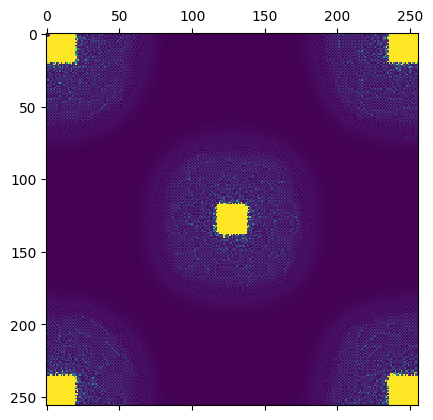

In [131]:
plt.matshow(np.clip(tenv.resv,0,10))